# 1. Motivación


El conjunto de datos es una muestra de transacciones realizadas en una tienda. Nos gustaría conocer mejor el comportamiento de compra del cliente frente a diferentes productos. 

Un primer problema es, entonces, predecir el monto de la compra de un usuario con la ayuda de la información contenida en las otras variables.

Este conjunto de datos también es particularmente conveniente para agrupar y quizás encontrar diferentes grupos de consumidores dentro de él como así también ser capaces de generar recomendaciones de productos.

# 2. Descripción del dataset

In [34]:
import pandas as pd
import numpy
import seaborn
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import collections

from sklearn.tree import DecisionTreeClassifier as dt 

from sklearn import linear_model 
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn import metrics  
from ml.visualization import plot_confusion_matrix, classifier_boundary
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

ModuleNotFoundError: No module named 'ml'

In [17]:
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null float64
dtypes: float64(3), int64(4), object(5)
memory usage: 49.2+ MB


In [8]:
ventas = pd.read_csv('retail_sales.csv')

In [9]:
ventas.sample(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
15560,1002344,P00355142,M,26-35,12,A,1,0,1,15.0,NaN,120.13
191497,1005593,P00114042,M,51-55,16,A,1,1,5,14.0,NaN,71.63
461798,1005092,P00190042,M,55+,14,C,1,1,3,4.0,5.0,109.68
140411,1003684,P00270042,M,26-35,17,C,4+,1,8,14.0,NaN,77.94
434218,1000877,P00058342,M,26-35,0,B,1,1,3,4.0,NaN,79.84


Podemos observar que la mayoría de las variables son categóricas. La única variable numérica es el precio de compra.

# 3. Análisis y visualización

La idea es empezar a explorar y analizar el conjunto de datos, responder a algunas preguntas que destaquen características del mismo junto con el uso de herramientas visuales.

## 3.1 Cantidad de usuarios s/ la cantidad de compras realizadas

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


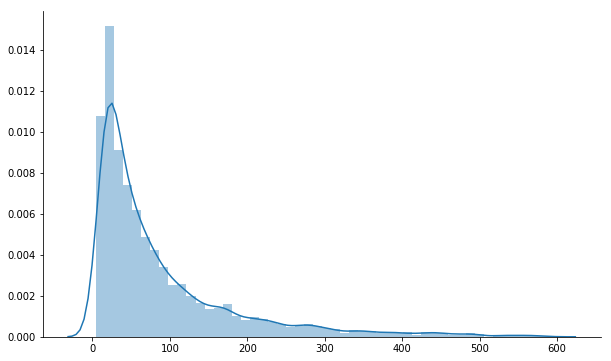

In [10]:
## Obtenemos la cantidad de compras por cada usuario
compras = ventas.groupby('User_ID').count()[['Product_ID']]


## Nos quedamos con las personas que hayan comprado menos de 600 veces (eliminamos los outliers)
compras_out = compras[compras['Product_ID'] < 600]

plt.figure(figsize=(10,6))
seaborn.distplot(compras_out, bins = 50)
seaborn.despine()

Es posible obsevar que la cantidad de compras por usuario no se distribuye normalmente. Se observa una asimetría derecha en la distribución. Esto se debe a que la mayor parte de las personas no ha realizado tantas compras. Por ejemplo, 122 personas compraron 17 veces, lo cual se puede observar en el histograma. La distribución es la exponencial

## 3.2 Cantidad de compras realizadas por rango de edad y por sexo

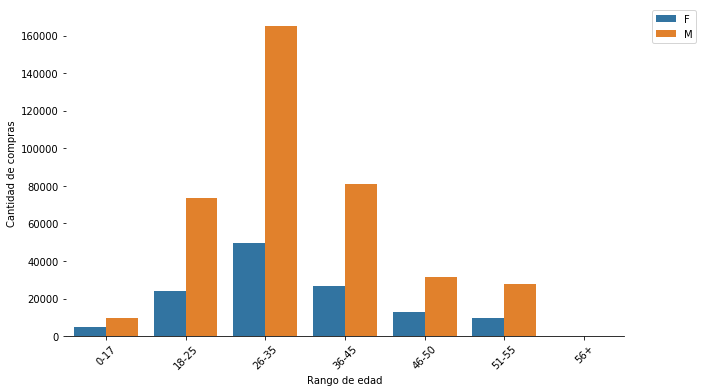

In [11]:
# Countplot separando por sexo y por edad

plt.figure(figsize=(10,6))

seaborn.countplot(data=ventas, x=ventas["Age"],
                hue='Gender',
                 order=['0-17','18-25','26-35','36-45','46-50','51-55','56+'])
plt.ylabel('Cantidad de compras')
plt.xlabel('Rango de edad')
#plt.ylim(0, 4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(left=True)

En este gráfico se puede observar lo siguiente:

1)Los hombres realizaron más compras que las mujeres, para todos los rangos de edad. 2)La mayor cantidad de compras fueron realizadas por las personas de entre 26 y 35 años.

## 3.3 Cantidad de compras por ocupación y por sexo

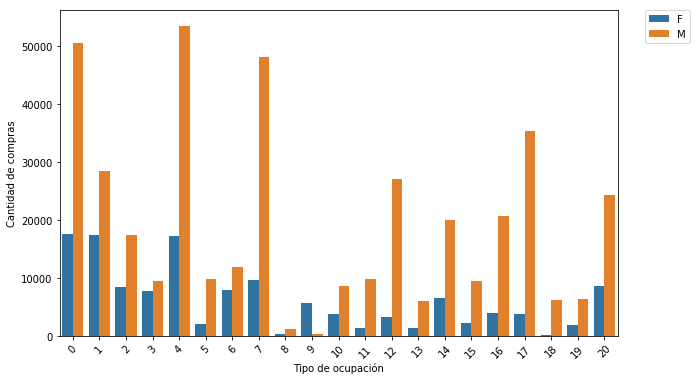

In [12]:
## Countplot separando por sexo y por ocupación

plt.figure(figsize=(10,6))

seaborn.countplot(data=ventas, x=ventas["Occupation"],
                hue='Gender')
plt.ylabel('Cantidad de compras')
plt.xlabel('Tipo de ocupación')
#plt.ylim(0, 4)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#seaborn.despine(left=True)

En este gráfico se puede observar lo siguiente:

1)Las personas que más han comprado son aquellas que tienen los tipos de ocupaciones "4, 0 y 7" 2)Para cada tipo de ocupación se observa que los hombres compraron más que las mujeres, EXCEPTO para la ocupación "9", en donde las mujeres compraron más que los hombres.

## 3.4 Cantidad de usuarios que han pagado precios atípicos, por tipo de ocupación

In [16]:
## Creo un nuevo DataFrame con todas las columnas, donde los valores de los precios son OUTLIERS. 
precios = ventas["Purchase"]

outliers_data = ventas[numpy.abs(precios-precios.mean()) >= (2.5*precios.std())]

pd.DataFrame(outliers_data['Occupation'].value_counts())




,Occupation
0,286
4,232
7,225
1,222
20,178
12,157
17,156
2,136
14,120
16,101


Esto significa que la ocupación tipo "0" es la que ha llegado a pagar precios más altos la mayoría de las veces.

## 3.5 Porcentaje que representan las compras de los productos Top 5 del total de compras, por rango etario

In [20]:
## Buscamos el top 5 de los productos más vendidos. Para que el groupby me de una tabla bonita, le tengo que poner reset_index()

top_productos = ventas.groupby('Product_Category_1').size().reset_index()
top_productos.rename(columns={0:'Cantidad vendida'}, inplace=True)

top_5 = top_productos.sort_values('Cantidad vendida', ascending=False)


#top_5_datos = ventas[ventas['Product_ID'] == top_5['Product_ID']]
prod_1 = ventas[ventas['Product_Category_1'] == 5]
prod_2 = ventas[ventas['Product_Category_1'] == 1]
prod_3 = ventas[ventas['Product_Category_1'] == 8]
prod_4 = ventas[ventas['Product_Category_1'] == 11]
prod_5 = ventas[ventas['Product_Category_1'] == 2]
frames = [prod_1, prod_2, prod_3, prod_4, prod_5]
top_5_datos = pd.concat(frames)




## Analizamos para cada rango de edad, qué % representa la compra de los productos 'top 5' respecto a la compra total 
## de productos de ese mismo rango etario

Edad_1 = round(top_5_datos[top_5_datos['Age'] == '0-17'].count()['User_ID'] / ventas[ventas['Age']  == '0-17'].count()['User_ID'] * 100, 2)
Edad_2 = round(top_5_datos[top_5_datos['Age'] == '18-25'].count()['User_ID'] / ventas[ventas['Age']  == '18-25'].count()['User_ID'] * 100, 2)
Edad_3 = round(top_5_datos[top_5_datos['Age'] == '26-35'].count()['User_ID'] / ventas[ventas['Age']  == '26-35'].count()['User_ID'] * 100, 2)
Edad_4 = round(top_5_datos[top_5_datos['Age'] == '36-45'].count()['User_ID'] / ventas[ventas['Age']  == '36-45'].count()['User_ID'] * 100, 2)
Edad_5 = round(top_5_datos[top_5_datos['Age'] == '46-50'].count()['User_ID'] / ventas[ventas['Age']  == '46-50'].count()['User_ID'] * 100, 2)
Edad_6 = round(top_5_datos[top_5_datos['Age'] == '51-55'].count()['User_ID'] / ventas[ventas['Age']  == '51-55'].count()['User_ID'] * 100, 2)
Edad_7 = round(top_5_datos[top_5_datos['Age'] == '56+'].count()['User_ID'] / ventas[ventas['Age']  == '56+'].count()['User_ID'] * 100, 2)

edades = {'Rango de edad' : ['0-17','18-25','26-35','36-45','46-50','51-55','56+'],'% ventas productos TOP 5' : [ Edad_1, Edad_2,Edad_3,Edad_4,Edad_5,Edad_6,Edad_7]}

pd.DataFrame(edades)

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in longlong_scalars


,Rango de edad,% ventas productos TOP 5
0,0-17,78.43
1,18-25,83.32
2,26-35,83.81
3,36-45,82.61
4,46-50,82.34
5,51-55,82.61
6,56+,NaN


La conclusión a la que llegamos es que en general el % de compras de los productos 'top 5' respecto al total de compras de cada grupo etario, es muy similar para todos los grupos (entre el 82-83% de las compras de cada grupo es de algún producto que está en el TOP 5). Salvo para los menores de 17 años que representan un porcentaje menor. Finalmente, las personas mayores a 56 años NO han comprado ninguno de estos productos más vendidos.

## 3.6 Análisis de los usuarios con +200 compras

### 3.6.1 Cantidad de compras s/ los años que haya estado viviendo la persona en la ciudad

TypeError: text() missing 1 required positional argument: 's'

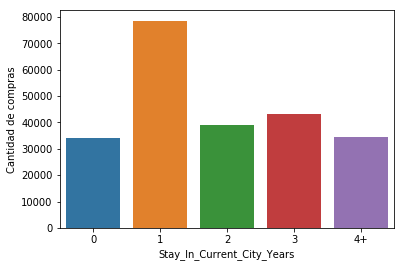

In [22]:
## Sacamos la cantidad de compras por usuario

usuarios = ventas.groupby('User_ID').size().reset_index()
usuarios.rename(columns={0:'Cantidad de compras'}, inplace=True)


## Nos quedamos con los usuarios con más de 200 compras

usuarios_200 = usuarios[usuarios['Cantidad de compras'] > 200]
usuarios_200 = pd.merge(usuarios_200, ventas, how = 'left', on = 'User_ID')
usuarios_200_1 = usuarios_200.drop_duplicates('User_ID')


## Analizamos la cantidad de compras según los años que haya estado viviendo la persona en su ciudad

años = usuarios_200_1.groupby('Stay_In_Current_City_Years')['Cantidad de compras'].sum().reset_index()
años = años.sort_values('Cantidad de compras', ascending=False)


g = seaborn.barplot(data=años, x='Stay_In_Current_City_Years', y='Cantidad de compras',
               order = ['0', '1', '2', '3', '4+'])

for index, row in años.iterrows():
    g.text(row.name,row['Cantidad de compras'], color='black', ha="center")

Dentro de las personas que realizaron mas de 200 compras, aquellas que hayan vivido menos de 2 años y más de 1 año, son las que más compras hicieron.
Quizás esto signifique que las personas que se mudan a una nueva ciudad, realizan la mayor cantidad de compras una vez que ya se han acomodado. Más específicamente, luego de transcurrido el primer año de estadía, y antes de cumplir los 2 años de vivir en esa ciudad.

### 3.6.2 Cantidad de compras s/ el género y s/ si está casado o soltero

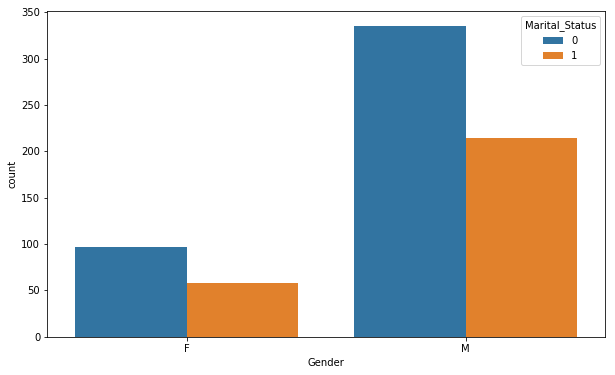

In [23]:
## Analizamos ahora, dentro de las personas con más de 200 compras, quiénes compraron más de acuerdo al
## sexo y a si están casados o no

plt.figure(figsize=(10,6))
seaborn.countplot(data=usuarios_200_1, x='Gender', hue = 'Marital_Status')

Dentro de las personas con + de 200 compras, los que más compraron por lejos son los hombres.
Por otro lado, los que más compraron son los solteros, ya sean hombres o mujeres.

## 3.7  Porcentaje de compras por ciudad dada la proporción de usuarios que contiene

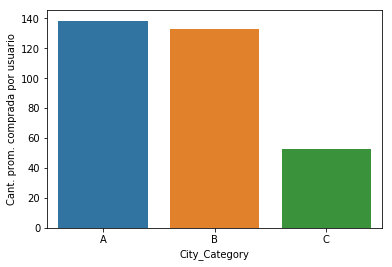

In [26]:
compras = ventas.groupby('City_Category').size().reset_index()
compras.rename(columns={0:'Cantidad vendida'}, inplace=True)

usuarios = ventas.groupby('User_ID').size().reset_index()
usuarios = pd.merge(usuarios,ventas, how = 'left', on = 'User_ID')
usuarios = usuarios.drop_duplicates('User_ID')


cantidad = usuarios.groupby('City_Category').size().reset_index()
cantidad.rename(columns={0:'Cantidad de compradores'}, inplace=True)


merge = pd.merge(compras,cantidad, how ='left', on= 'City_Category')
merge['Cant. prom. comprada por usuario'] = merge['Cantidad vendida'] / merge['Cantidad de compradores']

cantidad_usua = cantidad['Cantidad de compradores'].sum()
ventas_totales = ventas['User_ID'].count()

merge['% compradores'] = merge['Cantidad de compradores'] / cantidad_usua
merge['% ventas'] = merge['Cantidad vendida'] / ventas_totales

seaborn.barplot(data=merge, x='City_Category', y='Cant. prom. comprada por usuario')


El tipo de ciudad que más compradores tiene es el tipo "C" (53% de los compradores totales). Sin embargo, la cantidad comprada por medio por cada uno de estos compradores es MUY BAJA en relación a los otros tipos de ciudades (53 compras en promedio por usuario). La cantidad total comprada por los usuarios de las ciudades tipo "C" es un poco mayor que las ciudades tipo "A". Pero esto se debe a que muchos usuarios de las ciudades tipo "C" han realizado compras. Mientras que en las ciudades tipo "A", si bien son menos la cantidad de compradores, la cantidad promedio de compras que realizó cada uno es MUCHO MAYOR que en las ciudades tipo "C" (138 compras por usuario en promedio).

CONCLUSIÓN

Del total de compradores, el 53% son de las ciudades tipo "C", el 29% de las ciudades tipo "B" y el 18% de las ciudades tipo "A". A pesar de la alta concentración de compradores en las ciudades tipo "C", las ventas en este tipo de ciudades es sólo del 31% del total de ventas. Mientras que en las ciudades que más ventas se realizaron son en las tipo "B" (42%).

Para analizar que tipo de política de ventas se puede aplicar, habría que ver la cantidad de personas que tienen estos distintos tipos de ciudades, para ver el posible alcance que pueda llegar a tener una política de ventas.

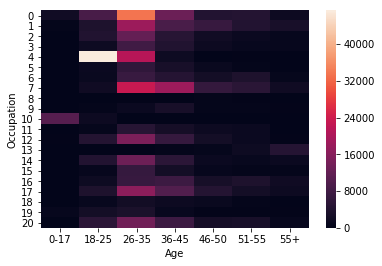

In [27]:
exp = ventas[['Occupation', 'Age']]
exp = exp.pivot_table(index='Occupation', columns= 'Age', aggfunc=len, fill_value=0)
seaborn.heatmap(exp)

En este gráfico se observa que la mayor probabilidad se da en dos casos: 1)El rango de edad de entre 18 y 25 años está relacionado con la ocupación tipo 4. La mayoría de las personas entre 18 y 25 años tiene la ocupación tipo 4. 2)El rango de edad entre 26 y 35 años está relacionado con la ocupación tipo 0.

El problema de este gráfico es el siguiente ¿Hay tantas de estas combinaciones porque siempre ocurren juntas, o sólo porque son los elementos más frecuentes? Como se puede observar en los dos gráficos de arriba, las ocupaciones tipo 0 y 4 son las que más se repiten, mientras que el rango de edad entre 26 y 35 años también es el que más se repite. Entonces capaz que las relaciones se debe a la gran cantidad de datos de estas categorías.

## 3.8 Conclusiones

El análisis y visualización del dataset nos permitió tener una primera aproximación acerca del comportamiento de los consumidores, teniendo en cuenta diferentes features, como su edad, ciudad, estado marital, cantidad de compras realizadas, etc. Algunas conclusiones podrían ser:
1) Los hombres compran mucho más que las mujeres. 
2) Los solteros compran mucho más que los casados.
3) En promedio, un usuario que vive en la ciudad "C" realizó menos de la mitad de compras que un usuario que vive en la ciudad "A" o "B".
4) Las personas suelen comprar más luego del primer año de mudados a una nueva ciudad.
5) 


# 4. Aprendizaje Supervisado

MOTIVACIÓN

1) Se desea predecir el sexo de un usuario (Female/Male): problema de clasificación binaria

Eliminamos los valores nulos para mayor simplicidad.
Las clases se encuentran desbalanceadas. Tener cuidado si el conjunto está balanceado o no. Porque si no está balanceado (tengo 98 positivas y 2 negativas,) , entonces me va a dar un accuracy alto. En estos casos una opción es analizar el recall.
Es decir, quiero que TP / Actual Positive (TP + FN) sea lo más alto posible. Es decir, que prediga la mayor cantidad de mujeres bien sobre el total de mujeres.

¿Qué estrategia se puede usar para lidiar con este problema del desbalanceo del dataset? Usamos cross validation.
El cross validation como funciona?
Lo que hace es generar conjuntos de validación o test que sean disjuntos.
Al conjunto de entrenamiento defino un N (5 o 10) y lo divido al conjunto de entrenamiento en esa cantidad de partes.
Lo que hago es repetir el procesos de entrenar cada subconjunto que utilizo como validación.
Ejemplo: divido en 5. Tomo como validación el 1, y entreno el 2,3,4,5 (la suma de esos), luego tomo el 2 como conjunto de validación y entreno el 1,3,4,5. Y asi sucesivamente.
A cada uno de estos casos, lo hago sobre diferentes valores de M (grado del polinomio)




2) Se desea predecir el rango de edad de un usuario: problema de clasificación multiclase


CONSIGNAS

Recordar que en el práctico de análisis y visualización se observó una leve correlación entre dos variables (Age y Occupation). Esto da indicio de que la ocupación puede ser un feature de gran importancia a la hora de predecir la edad de un usuario.
Para ambos problemas, seguir los procedimientos tradicionales en cuanto a la división de los datos, cross-validation, ajuste de hiperparámetros, etc.

## 4.1 Predecir el sexo del usuario

In [30]:
retail = pd.read_csv('retail_sales.csv')

data = retail.dropna()
data=data.drop(["User_ID","Product_ID"],axis=1)
X = data.drop(['Gender'], axis=1)

y = data['Gender']

age=X["Age"]

X=X.drop(["Age"],axis=1)

X['Occupation'] = X['Occupation'].astype('str')
X['Product_Category_1'] = X['Product_Category_1'].astype('str')
X['Product_Category_2'] = X['Product_Category_2'].astype('str')
X['Product_Category_3'] = X['Product_Category_3'].astype('str')
X['Marital_Status'] = X['Marital_Status'].astype('str')

X = pd.get_dummies(X)
age = age.replace({'0-17':0, '18-25':1, '26-35':2, '36-45':3,'46-50':4, '51-55':5, '55+':6})
age=preprocessing.minmax_scale((age))

X["Purchase"]=preprocessing.minmax_scale((X["Purchase"]))
X.shape
X.insert(value=age,loc=1,column="Age")

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [31]:
#Female (1) y Male (0)

y = y.replace({'F':1, 'M':0})


data.groupby(['Gender']).size()

Gender
F     36932
M    127346
dtype: int64

Esta desbalanceado el conjunto de datos, contiene 127346 hombres y 36932 mujeres.

In [32]:
## Split de los datos en train, validation and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

### 4.1.1  Stochastic Gradient Descent (SGD)

In [33]:
sgd = linear_model.SGDClassifier(max_iter=10, tol=None,class_weight='balanced')

exploring_params = {'learning_rate': ['constant',"optimal"],
      'eta0': [1e-5, 1e-4,1e-3, 1e-2, 1e-1],  # Tasa de entrenamiento
      'alpha': [1e-3, 1e-2, 1e-1]     
}  # Tasa de regularización
    
model = GridSearchCV(sgd, exploring_params, cv=5, scoring='accuracy')  # cv -> CROSS VALIDATION


model.fit(X_train, y_train)

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
print()

    
## Reporte clasificación para Conjunto Entrenamiento
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Entrenamiento):", end="\n\n")
print(classification_report(y_train, model.predict(X_train)), end="\n\n")

print("================================================", end="\n\n")


## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_val, model.predict(X_val)
print(classification_report(y_val, model.predict(X_val)), end="\n\n")


print("================================================", end="\n\n")


## Matriz de Confusión para el Conjunto de Entrenamiento

plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Entrenamiento para" )
plt.show()

## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Validación")
plt.show()


C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max

Mejor conjunto de parámetros:
{'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.622 (+/-0.000) para los parámetros {'alpha': 0.001, 'eta0': 1e-05, 'learning_rate': 'constant'}
Exactitud: 0.591 (+/-0.001) para los parámetros {'alpha': 0.001, 'eta0': 1e-05, 'learning_rate': 'optimal'}
Exactitud: 0.631 (+/-0.000) para los parámetros {'alpha': 0.001, 'eta0': 0.0001, 'learning_rate': 'constant'}
Exactitud: 0.595 (+/-0.001) para los parámetros {'alpha': 0.001, 'eta0': 0.0001, 'learning_rate': 'optimal'}
Exactitud: 0.594 (+/-0.001) para los parámetros {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'constant'}
Exactitud: 0.594 (+/-0.001) para los parámetros {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'optimal'}
Exactitud: 0.618 (+/-0.003) para los parámetros {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'constant'}
Exactitud: 0.592 (+/-0.001) para los parámetros {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'optimal'}
Exactitud: 0.590 (+/

NameError: name 'plot_confusion_matrix' is not defined

En este caso, tenemos un accuracy alto de hombres (0) porque hay mayor cantidad de hombres. 
Pero lo que nos interesa es tener un recall alto de mujeres. Es decir, que mi % de predicciones correctas de mujeres sea lo más alto posible. Ejemplo: si tengo 100 mujeres, y predigo 90 bien. Tengo un recall para las mujeres del 90%.

En este caso, para el conjunto de entrenamiento, tenemoos un recall muy bajo para las mujeres con el SGD.

Sobre el conjunto de test

In [35]:
## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_test, model.predict(X_test)), end="\n\n")


## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Evaluacion")
plt.show()

Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):

              precision    recall  f1-score   support

           0       0.80      0.75      0.78     19108
           1       0.29      0.34      0.31      5534

   micro avg       0.66      0.66      0.66     24642
   macro avg       0.54      0.55      0.54     24642
weighted avg       0.68      0.66      0.67     24642




NameError: name 'plot_confusion_matrix' is not defined

También nos da un recall muy bajo. Entonces descartamos el algoritmo SGD.

### 4.1.2 Decision Tree

In [36]:
# Instantiate with a max depth of 3
tree_model = dt(class_weight='balanced', random_state=0)  


exploring_params = {'criterion': ['gini',"entropy"],
      'splitter': ["best","random"],  # Tasa de entrenamiento
      'max_depth': [6,12,24,40]     
}  # Tasa de regularización
    
model = GridSearchCV(tree_model, exploring_params, cv=5, scoring='recall')  # cv -> CROSS VALIDATION


model.fit(X_train, y_train)

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
print()

    
## Reporte clasificación para Conjunto Entrenamiento
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Entrenamiento):", end="\n\n")
print(classification_report(y_train, model.predict(X_train)), end="\n\n")

print("================================================", end="\n\n")


## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_val, model.predict(X_val)
print(classification_report(y_test, model.predict(X_test)), end="\n\n")


print("================================================", end="\n\n")


## Matriz de Confusión para el Conjunto de Entrenamiento

plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train)),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Entrenamiento para" )
plt.show()

## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Validación")
plt.show()


Mejor conjunto de parámetros:
{'criterion': 'gini', 'max_depth': 24, 'splitter': 'random'}

Puntajes de la grilla:

Exactitud: 0.621 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 6, 'splitter': 'best'}
Exactitud: 0.619 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 6, 'splitter': 'random'}
Exactitud: 0.668 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 12, 'splitter': 'best'}
Exactitud: 0.653 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 12, 'splitter': 'random'}
Exactitud: 0.678 (+/-0.001) para los parámetros {'criterion': 'gini', 'max_depth': 24, 'splitter': 'best'}
Exactitud: 0.688 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 24, 'splitter': 'random'}
Exactitud: 0.563 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 40, 'splitter': 'best'}
Exactitud: 0.585 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 40, 'splitter': 'random'}
Exactitud: 0.591 (+/-0

NameError: name 'plot_confusion_matrix' is not defined

Sobre el conjunto de Test

In [ ]:
## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_test, model.predict(X_test)), end="\n\n")


## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Evaluacion")
plt.show()

Decision Tree es el mejor modelo, ya que tiene una tasa de recall para las mujeres bastante alto en comparación con los otros modelos. Y al estar desbalanceado el dataset (pocas mujeres), el recall es una buena métrica de evaluación.

### 4.1.3 Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

results = pd.DataFrame(columns=('clf', 'best_acc'))

tree_param = {
    'max_leaf_nodes': [None] + list(numpy.linspace(40, 200, 500).astype(int)),
    'min_samples_split': [13, 14, 15, 16],
    'min_samples_leaf':(range(4,15)),
    'bootstrap': [True, False]
}


tree = RF(random_state=42, class_weight='balanced', n_estimators=50)


tree.fit(X_train, y_train)


## Reporte clasificación para Conjunto Entrenamiento
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Entrenamiento):", end="\n\n")
print(classification_report(y_train, tree.predict(X_train)), end="\n\n")

print("================================================", end="\n\n")


## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_val, model.predict(X_val)
print(classification_report(y_test, tree.predict(X_test)), end="\n\n")


print("================================================", end="\n\n")


## Matriz de Confusión para el Conjunto de Entrenamiento

plot_confusion_matrix(confusion_matrix(y_train, tree.predict(X_train)),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Entrenamiento para" )
plt.show()

## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Validación")
plt.show()

Reporte de clasificación para el mejor clasificador (sobre Conjunto de Entrenamiento):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86571
           1       1.00      1.00      1.00     25137

   micro avg       1.00      1.00      1.00    111708
   macro avg       1.00      1.00      1.00    111708
weighted avg       1.00      1.00      1.00    111708



Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     19108
           1       0.61      0.42      0.50      5534

   micro avg       0.81      0.81      0.81     24642
   macro avg       0.73      0.67      0.69     24642
weighted avg       0.79      0.81      0.80     24642





NameError: name 'plot_confusion_matrix' is not defined

In [ ]:
Sobre el conjunto de Test

In [ ]:
## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_test, tree.predict(X_test)
print(classification_report(y_test, tree.predict(X_test)), end="\n\n")


## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train.unique(), title="Matriz de confusión del Conjunto de Evaluacion")
plt.show()

CONCLUSIÓN

El mejor modelo para predecir el sexo de la persona es el Decision Tree, ya que al estar desbalanceado el dataset (pocas mujeres), buscamos que la tasa de recall de las mujeres sea lo más alta posible. 
Como inputs utilizamos: la ocupación, categoria de producto 1, 2 y 3, edad y estado marital, el precio del producto.
Convertimos en dummies las variables categóricas, y le aplicamos minmax_scale al precio (variable numérica).

## 4.2 Predecir la edad del usuario

In [40]:
data_1 = retail.dropna()
data_1 = data_1.drop(["User_ID","Product_ID"],axis=1)
X_1 = data_1.drop(['Age'], axis=1)

age_1=data_1["Age"]


X_1['Occupation'] = X_1['Occupation'].astype('str')
X_1['Product_Category_1'] = X_1['Product_Category_1'].astype('str')
X_1['Product_Category_2'] = X_1['Product_Category_2'].astype('str')
X_1['Product_Category_3'] = X_1['Product_Category_3'].astype('str')
X_1['Marital_Status'] = X_1['Marital_Status'].astype('str')


X_1 = pd.get_dummies(X_1)



X_1 = pd.get_dummies(X_1)
age_1 = age_1.replace({'0-17':0, '18-25':1, '26-35':2, '36-45':3,'46-50':4, '51-55':5, '55+':6})

X_1["Purchase"]=preprocessing.minmax_scale((X_1["Purchase"]))
X_1.shape
y_1 = age_1


In [41]:
data_1.groupby(['Age']).size()

Age
0-17      4789
18-25    30889
26-35    65916
36-45    32758
46-50    13135
51-55    11018
55+       5773
dtype: int64

In [42]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.15, random_state=0)

X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_1, y_train_1, test_size=0.20, random_state=0)

In [43]:
# Instantiate with a max depth of 3
model_tree = dt(class_weight='balanced', random_state=0)  



model_tree.fit(X_train_1, y_train_1)


    
## Reporte clasificación para Conjunto Entrenamiento
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Entrenamiento):", end="\n\n")
print(classification_report(y_train_1, model_tree.predict(X_train_1)), end="\n\n")

print("================================================", end="\n\n")


## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_val_1, model_tree.predict(X_val_1)
print(classification_report(y_test, model_tree.predict(X_test_1)), end="\n\n")


print("================================================", end="\n\n")


## Matriz de Confusión para el Conjunto de Entrenamiento

plot_confusion_matrix(confusion_matrix(y_train_1, model_tree.predict(X_train_1)),
                      classes=y_train_1.unique(), title="Matriz de confusión del Conjunto de Entrenamiento para" )
plt.show()

## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train_1.unique(), title="Matriz de confusión del Conjunto de Validación")
plt.show()

Reporte de clasificación para el mejor clasificador (sobre Conjunto de Entrenamiento):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3271
           1       1.00      1.00      1.00     21078
           2       1.00      1.00      1.00     44527
           3       1.00      1.00      1.00     22486
           4       1.00      1.00      1.00      8924
           5       1.00      1.00      1.00      7506
           6       1.00      1.00      1.00      3916

   micro avg       1.00      1.00      1.00    111708
   macro avg       1.00      1.00      1.00    111708
weighted avg       1.00      1.00      1.00    111708



Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):

              precision    recall  f1-score   support

           0       0.65      0.03      0.05     19108
           1       0.22      0.19      0.20      5534
           2       0.00      0.00      0.00         0
           

C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Usuario\Anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


NameError: name 'plot_confusion_matrix' is not defined

Sobre el conjunto de Test

In [44]:
## Reporte clasificación para Conjunto Evaluación
print("Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):", end="\n\n")
y_true, y_pred = y_test_1, model_tree.predict(X_test_1)
print(classification_report(y_test_1, model_tree.predict(X_test_1)), end="\n\n")


## Matriz de Confusión para el Conjunto de Evaluación 

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=y_train_1.unique(), title="Matriz de confusión del Conjunto de Evaluacion")
plt.show()

Reporte de clasificación para el mejor clasificador (sobre Conjunto de Evaluación):

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       736
           1       0.58      0.59      0.58      4680
           2       0.62      0.60      0.61      9988
           3       0.47      0.49      0.48      4833
           4       0.41      0.42      0.42      1956
           5       0.35      0.37      0.36      1620
           6       0.42      0.42      0.42       829

   micro avg       0.54      0.54      0.54     24642
   macro avg       0.51      0.52      0.52     24642
weighted avg       0.55      0.54      0.55     24642




NameError: name 'plot_confusion_matrix' is not defined

Al igual que en el modelo para predecir el sexo, el decision tree classifier obtuvó mejores resultados en el recall y F-1 con respecto al modelo Random Forest.